In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [2]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset in Google Drive
data_dir = "/content/drive/MyDrive/augmented_dataset"

# Parameters
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
SEED = 123

# Load dataset with 80/10/10 split
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=SEED
)

valtest_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=SEED
)

# Split valtest_ds into 50/50 → 10% validation, 10% test
val_batches = valtest_ds.take(len(valtest_ds) // 2)
test_batches = valtest_ds.skip(len(valtest_ds) // 2)

# Normalize images
def format_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_batches = train_ds.map(format_image).prefetch(tf.data.AUTOTUNE)
validation_batches = val_batches.map(format_image).prefetch(tf.data.AUTOTUNE)
test_batches = test_batches.map(format_image).prefetch(tf.data.AUTOTUNE)

# Check dataset sizes
print("Train batches:", len(train_batches))
print("Validation batches:", len(validation_batches))
print("Test batches:", len(test_batches))

# Preview one batch
for image_batch, label_batch in train_batches.take(1):
    print(image_batch.shape, label_batch.numpy())


Mounted at /content/drive
Found 388 files belonging to 2 classes.
Using 311 files for training.
Found 388 files belonging to 2 classes.
Using 77 files for validation.
Train batches: 10
Validation batches: 1
Test batches: 2
(32, 160, 160, 3) [1 1 1 0 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1]


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Parameters
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 32
num_classes = 2

# Base MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
     input_shape=IMAGE_SIZE + (3,),
     include_top=False,
     weights="imagenet",
     alpha=0.35 # depth multiplier
     )

base_model.trainable = False # freeze base

# Build model
model = models.Sequential([
     base_model,
     layers.GlobalAveragePooling2D(),
     layers.Dense(8, activation="relu"),
     layers.Dropout(0.5),
     layers.Dense(num_classes, activation="softmax")
     ])

model.summary()
optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.005)

# Compile
model.compile( optimizer=optimizer1, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )

# Train
EPOCHS = 60
hist = model.fit( train_batches, validation_data=validation_batches, epochs=EPOCHS )


2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_0.35_160            │ (None, 5, 5, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        10,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,474 (1.60 MB)

 Trainable params: 10,266 (40.10 KB)

 Non-trainable params: 410,208 (1.56 MB)

Epoch 1/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.5440 - loss: 0.7914 - val_accuracy: 0.7188 - val_loss: 0.7101
Epoch 2/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step - accuracy: 0.6981 - loss: 0.6033 - val_accuracy: 0.7812 - val_loss: 0.5307
Epoch 3/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.7330 - loss: 0.4969 - val_accuracy: 0.8750 - val_loss: 0.3795
Epoch 4/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.7597 - loss: 0.4438 - val_accuracy: 0.8438 - val_loss: 0.3608
Epoch 5/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7745 - loss: 0.4096 - val_accuracy: 0.8750 - val_loss: 0.2877
Epoch 6/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.8459 - loss: 0.3576 - val_accuracy: 0.9062 - val_loss: 0.2285
Epoch 7/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.8676 - loss: 0.2866 - val_accuracy: 0.9688 - val_loss: 0.1874
Epoch 8/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.8840 - loss: 0.2540 - val_accuracy: 0.9375

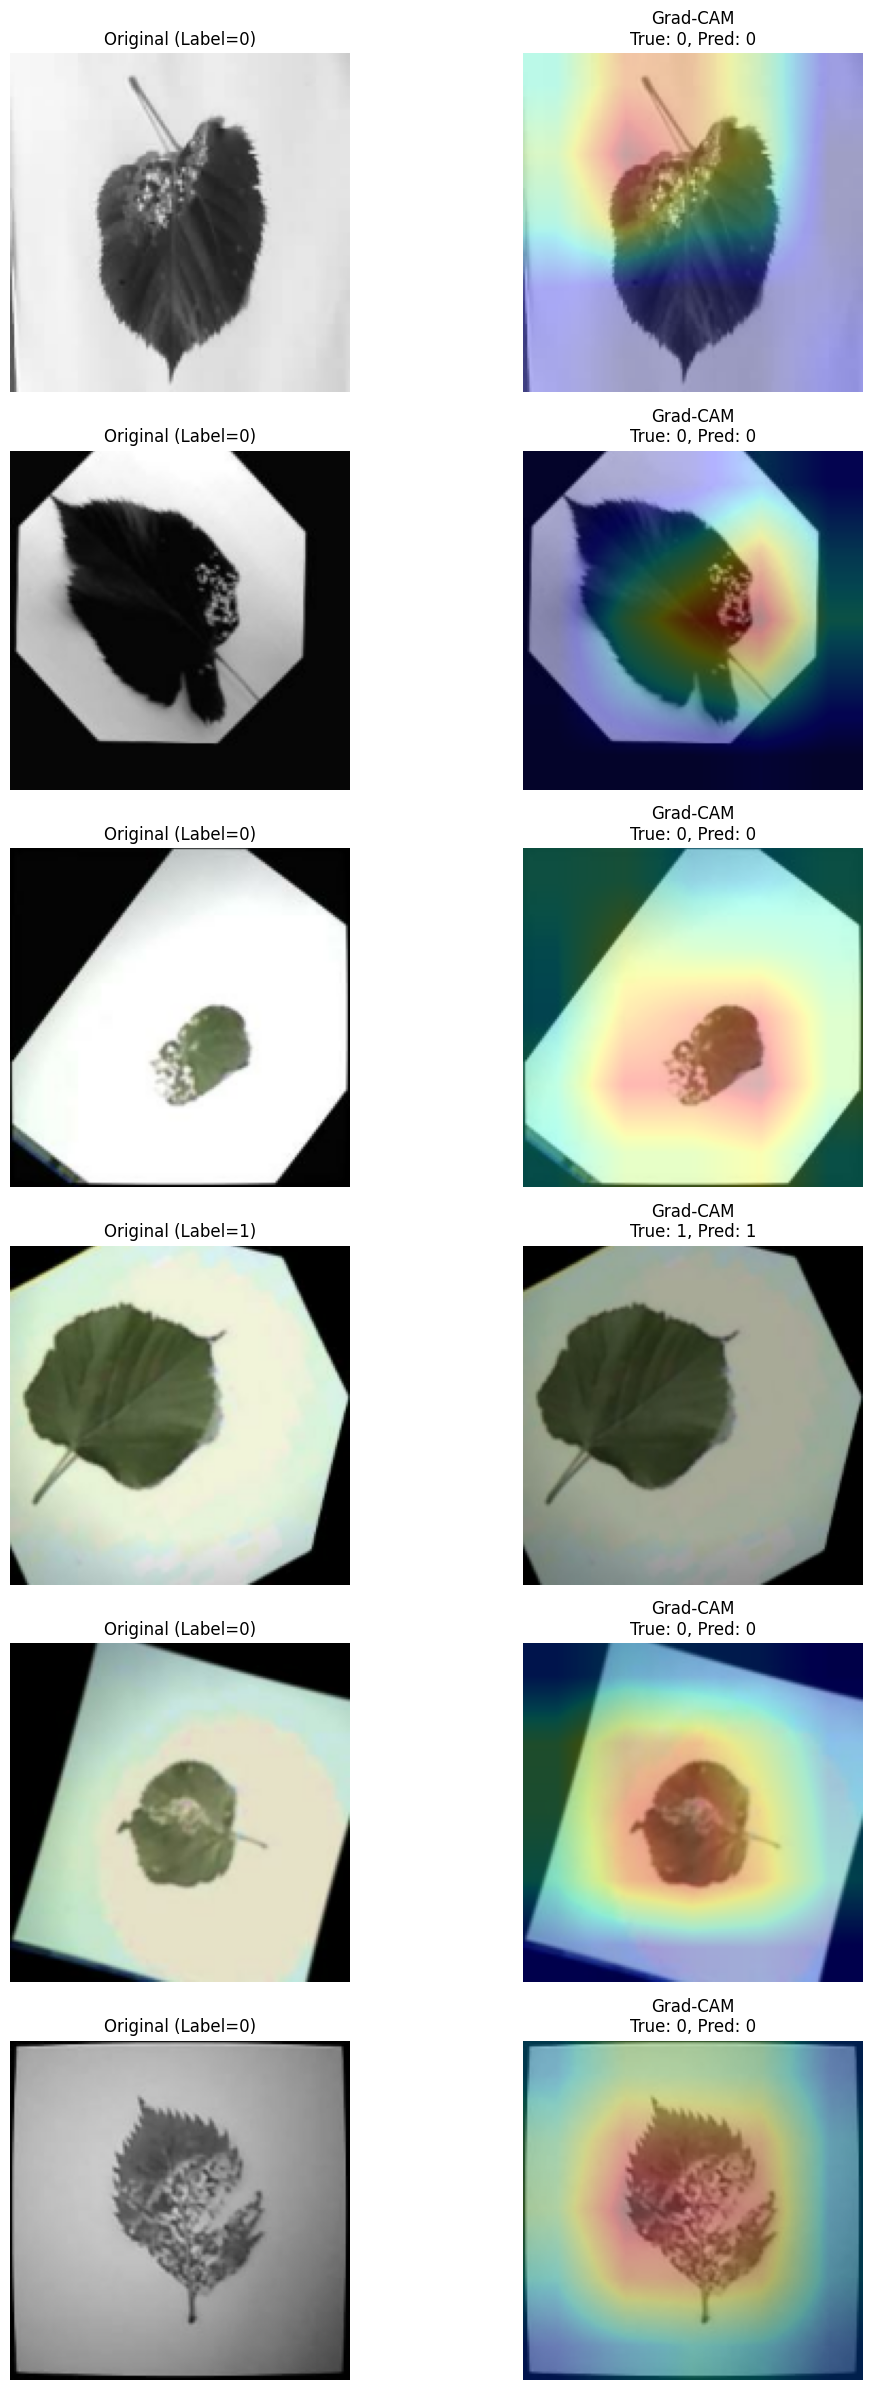

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Grad-CAM function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1", pred_index=None):
    base_model = model.get_layer("mobilenetv2_0.35_160")
    last_conv_layer = base_model.get_layer(last_conv_layer_name).output

    inputs = base_model.input
    x = base_model.output
    for layer in model.layers[1:]:
        x = layer(x)
    outputs = x

    grad_model = tf.keras.models.Model(
        inputs=inputs,
        outputs=[last_conv_layer, outputs]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), predictions.numpy()[0]

# Superimpose heatmap on image
def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_rgb = plt.cm.jet(heatmap_resized)[:, :, :3]
    overlay = img * (1 - alpha) + heatmap_rgb * 255 * alpha
    overlay = np.clip(overlay, 0, 255).astype("uint8")
    return overlay

# Display multiple images with original + Grad-CAM, showing true and predicted labels
def show_gradcam_batch(model, dataset, class_names=None, num_images=6, alpha=0.4):
    image_batch, label_batch = next(iter(dataset))
    image_batch, label_batch = image_batch[:num_images], label_batch[:num_images]

    plt.figure(figsize=(12, 4 * num_images))
    for i in range(num_images):
        img = (image_batch[i].numpy() * 255).astype("uint8")
        label = label_batch[i].numpy()
        heatmap, preds = make_gradcam_heatmap(tf.expand_dims(image_batch[i], axis=0), model)
        overlay = overlay_heatmap(img, heatmap, alpha=alpha)
        pred_label = np.argmax(preds)

        # Use class names if provided
        true_label_name = class_names[label] if class_names else label
        pred_label_name = class_names[pred_label] if class_names else pred_label

        # Original
        plt.subplot(num_images, 2, 2*i+1)
        plt.imshow(img)
        plt.title(f"Original (Label={true_label_name})")
        plt.axis("off")

        # Grad-CAM overlay
        plt.subplot(num_images, 2, 2*i+2)
        plt.imshow(overlay)
        plt.title(f"Grad-CAM\nTrue: {true_label_name}, Pred: {pred_label_name}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Optional: get class names from dataset
class_names = test_batches.class_names if hasattr(test_batches, "class_names") else None

# Run on test set
show_gradcam_batch(model, test_batches, class_names=class_names, num_images=6, alpha=0.3)
